This script will assign coordinates for ISRE motifs from Zefeng Wangs 2013 papers found within introns. 

It will also write files for coordinates for 100 bps flanking ISRE motifs. 

It will also analyze the distribution of ISREs within introns.

It will also analyze the distribution of mutations around ISREs

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import regex as re2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
import numpy as np

In [ ]:
# This function will get the coordinates of ISRE motifs throughout the genome. 
def findISRESWithinChromosome(seqdirectory,chromosome,ISREfile,writefile):

    with open(ISREfile) as f:
        ISREs = [line.strip() for line in f]
    #chrms = range(1, 23)
    #chrms.extend(['X', 'Y'])
    # print(chrms)
    #chrms_act = ['chr' + str(i) for i in chrms]

    with open(writefile,'w') as fw:
        #for chromosome in chrms_act:
        for rec in SeqIO.parse(open(seqdirectory + '/' + chromosome + '.fa', 'rU'), 'fasta'):
            seq_chrm = rec.seq
            seq_chrm_revcom = seq_chrm.complement()
        for isre in ISREs:
            isre_coords_for = [[m.start(), m.end()] for m in re2.finditer(isre, str(seq_chrm),overlapped=True)]
            for coord in isre_coords_for:
                fw.write(chromosome + '\t' + str(coord[0]) + '\t' + str(coord[1]) +'\t' + isre + '\t' + '+' +'\n')
            isre_coords_rev = [[m.start(), m.end()] for m in re2.finditer(isre[::-1], str(seq_chrm_revcom), overlapped=True)]
            for coord in isre_coords_rev:
                fw.write(chromosome + '\t' + str(coord[0]) + '\t' + str(coord[1]) + '\t' + isre + '\t' + '-' + '\n')

In [ ]:
# Run the above function for each chromosome
chrms = range(1, 23)
chrms.extend(['X', 'Y'])
print(chrms)
chrms_act = ['chr' + str(i) for i in chrms]
    
for chrom in chrms_act:
    print chrom
    findISRESWithinChromosome("/home/shared/hg38/hg38_chroms",chrom,"../data/ISE_ISS_ZWpaper.tsv","../temp/Chromosomedata_ISREs/"+chrom+"_ISRE_locations.bed")
    #findISRESWithinChromosome("hg38_chroms",chrom,"ISE_ISS_ZWpaper.tsv","Chromosomedata_ISEandISSs/"+chrom+"_ISS_locations.bed")

In [ ]:
# Intersect ISRE coordinate file with the intron coordinate file to get ISREs found in introns
!./runISREs_Intersect_Introns.sh

In [ ]:
# Concatenatate all the ISRE intersecting introns per chromosome data into one file 
!cat ../temp/Chromosomedata_ISREs/Introns_Intersect_chr*_ISREs.txt > ../temp/Introns_Intersect_ISREs.txt

In [ ]:
# This function checks if the intron and the ISRE are on the same strand and only returns those that are 
def grabSameStrandData(datafile,strandind1,strandind2):
    data = pd.read_csv(datafile,sep="\t",header=None)
    print data.shape
    data_sameStrand= data[data[strandind1]==data[strandind2]]
    print data_sameStrand.shape
    return(data_sameStrand)

In [ ]:
# Run the grab same strand data function for introns intersecting ISREs
introns_Intersect_ISREs_sameStrand = grabSameStrandData("../temp/Introns_Intersect_ISREs.txt",4,10)
print introns_Intersect_ISREs_sameStrand.shape
introns_Intersect_ISREs_sameStrand.head()

In [ ]:
# Lets see how many unique ISREs are 
introns_Intersect_ISREs_sameStrand.iloc[:,range(6,11)].drop_duplicates().shape

In [ ]:
# If there are multiple introns associated with one intron, we want to randomly pick one intron for each mutation
def getSingleLocationForISRESwithIntron(data):
    justISREs = data.iloc[:,[6,7,8,9,10]]
    duplicateRows = justISREs.duplicated(keep=False)
    duplicated_rows = data[duplicateRows]
    print duplicated_rows.shape
    nonduplicated_rows = data[~duplicateRows]
    print nonduplicated_rows.shape
    duplicatedrows_single = duplicated_rows.groupby([6,7,8,10]).apply(lambda x :x.iloc[np.random.randint(0, len(x))])
    combinerows = pd.concat([nonduplicated_rows,duplicatedrows_single])
    combinerows_sorted = combinerows.sort_values(by=[0,1,2])
    return combinerows_sorted

In [ ]:
# Randomly pick intron for each mutation
introns_ISREs_singleLocation = getSingleLocationForISRESwithIntron(introns_Intersect_ISREs_sameStrand)
print introns_ISREs_singleLocation.shape
introns_ISREs_singleLocation.head()

In [ ]:
introns_ISREs_singleLocation.to_csv("../processed_data/Introns_Intersect_ISREs_singleISRElocation.txt",sep="\t",header=False,index=False)

In [5]:
# This function will get the difference between start site of feature of interest and see how far it is from the start
# of the intron
def getDataForAnydistribution(data,window_5,window_3):
    data_plus = data[data[4]=='+']
    data_minus = data[data[4]=='-']
    valid_data_plus = data_plus[(data_plus[7] >= data_plus[1]+window_5) & (data_plus[7] <= data_plus[2]-1-window_3)]
    valid_data_minus = data_minus[(data_minus[7] >= data_minus[1]+window_3) & (data_minus[7] <= data_minus[2]-1-window_5)]
    data_dist_plus = (valid_data_plus[7]-valid_data_plus[1])/(valid_data_plus[2]-valid_data_plus[1])
    data_dist_minus = (valid_data_minus[7] - valid_data_minus[1]) / (valid_data_minus[2] - valid_data_minus[1])
    return pd.concat([data_dist_plus,1-data_dist_minus])

In [6]:
introns_ISREs_singleLocation = pd.read_csv("../processed_data/Introns_Intersect_ISREs_singleISRElocation.txt",header=None,sep="\t")
print introns_ISREs_singleLocation.shape
introns_ISREs_singleLocation.head()

(23964596, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925804,925810,GTGTGG,+
1,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925820,925826,GTATTT,+
2,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925805,925811,TGTGGG,+
3,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925842,925848,AGGGGG,+
4,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925839,925845,GGGAGG,+


In [7]:
introns_ISREs_singleLocation_dist = getDataForAnydistribution(introns_ISREs_singleLocation,0,0)
introns_ISREs_singleLocation_dist.head()

0    0.033058
1    0.165289
2    0.041322
3    0.347107
4    0.322314
dtype: float64

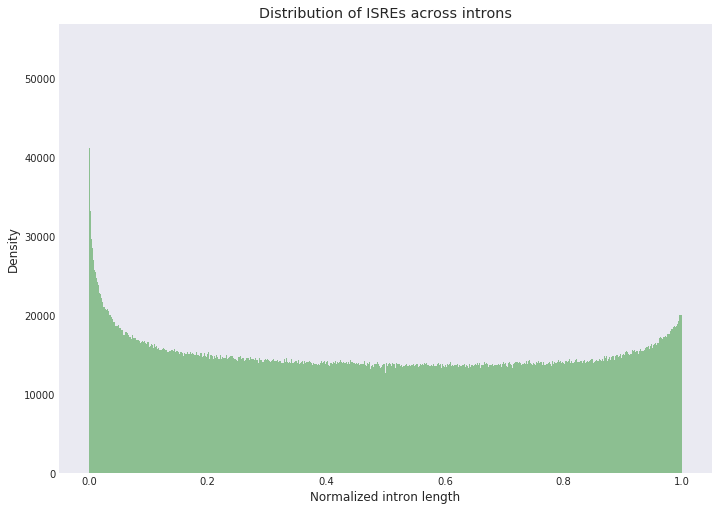

In [10]:
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_ISREs_singleLocation_dist, bins=1582, kde=False, rug=False, color="green");
#plt.ylim([0,2000])
plt.ylabel('Density')
plt.xlabel('Normalized intron length')
plt.title("Distribution of ISREs across introns")
plt.show()

In [3]:
# This function will write the coordinates around ISREs according to the window size given
def writeWindowsAroundISREsInIntrons(datafile,window,writefile):
    data = pd.read_csv(datafile,header=None,sep="\t")
    #valid_data = data[((data[7]- 1.5*window) >= data[1]) & ((data[8]+ 1.5*window) <= data[2])]
    valid_data = data
    new_ISRE_data = {"chrom":valid_data[6],"start":valid_data[7]-window,"end":valid_data[8]+window,"motif":valid_data[9],"strand":valid_data[10]}
    ISRE_datadf = pd.DataFrame(new_ISRE_data,columns=["chrom","start","end","motif","strand"])
    ISRE_datadf.to_csv(writefile,sep="\t",header=False,index=False)

In [4]:
writeWindowsAroundISREsInIntrons("../processed_data/Introns_Intersect_ISREs_singleISRElocation.txt",50,"../processed_data/ISREs_Intersect_Introns_singleISRElocation_50bpWindow.bed")

In [ ]:
introns_ISREs_Muts_dist = ISREs_Intersect_introns_Intersect_muts_SameStrand[6] - ISREs_Intersect_introns_Intersect_muts_SameStrand[1]
introns_ISREs_Muts_dist.head()

In [ ]:
# Plot the distribution of mutations across 100 window of ISREs 
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(introns_ISREs_Muts_dist, bins=106, norm_hist=True, kde=False, rug=False, color="green");
#plt.ylim([0,500])
plt.ylabel('Density')
plt.xlabel('100 bp window around ISRE')
plt.axvline(x=50, color='k', linestyle='--')
plt.axvline(x=55, color='k', linestyle='--')
plt.xticks([0,50,55,105])
ax = plt.gca()
ax.set_xticklabels([-50,0,5,50])
plt.title("Distribution of mutations around ISREs")
plt.show()

Let's look at the frequency of ISRE motifs within introns 

In [2]:
# Reads in ISRE motifs found in introns file
introns_ISREs_singleLocation = pd.read_csv("../processed_data/Introns_Intersect_ISREs_singleISRElocation.txt",header=None,sep="\t")
print introns_ISREs_singleLocation.shape
introns_ISREs_singleLocation.head()

(23964596, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925804,925810,GTGTGG,+
1,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925820,925826,GTATTT,+
2,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925805,925811,TGTGGG,+
3,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925842,925848,AGGGGG,+
4,chr1,925800,925921,NM_152486,+,SAMD11,chr1,925839,925845,GGGAGG,+


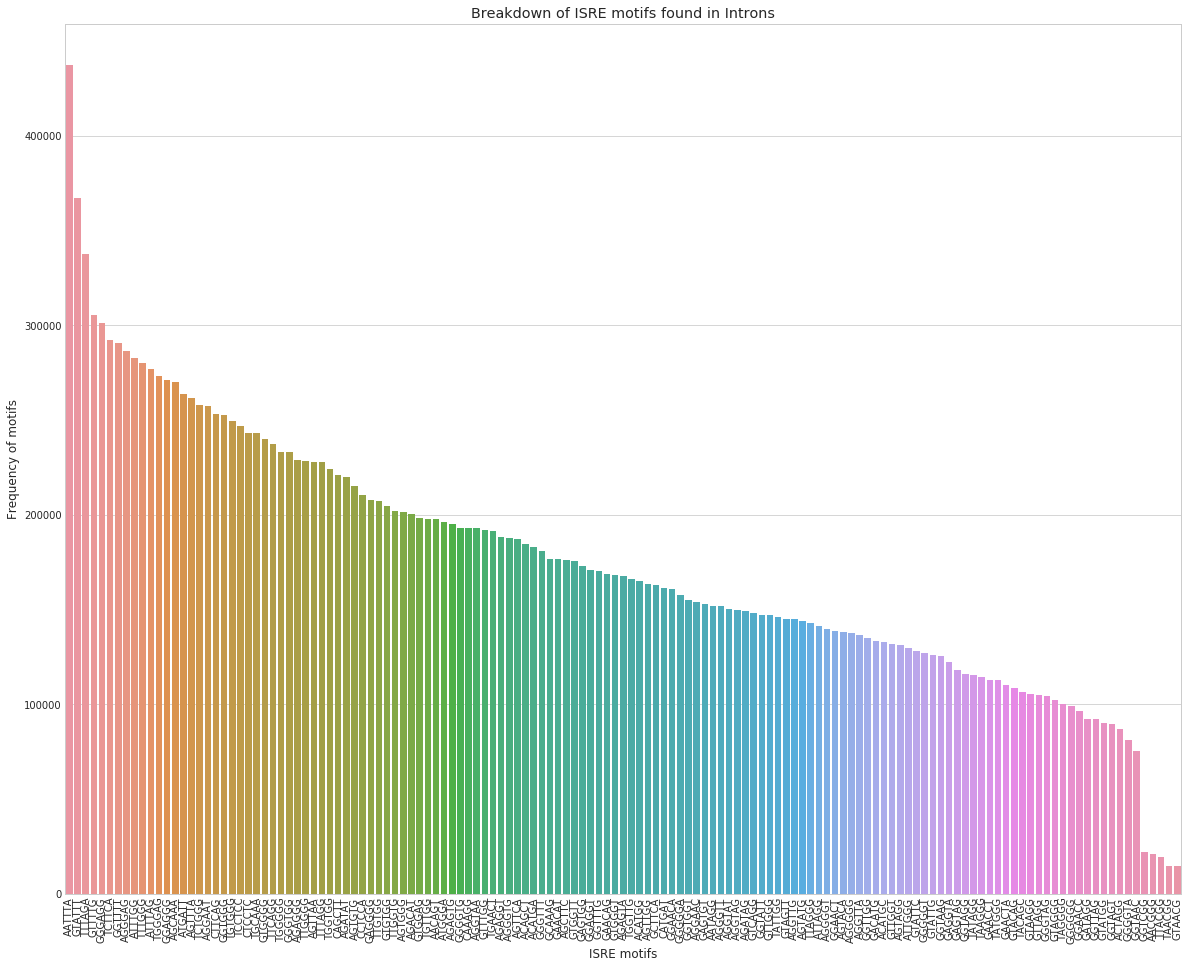

In [3]:
# Look for overrepresented ISREs in introns
ISREs_inIntron_Count = introns_ISREs_singleLocation[9].value_counts()
ISREs_inIntron_Count_df = pd.DataFrame({"Numbers":ISREs_inIntron_Count.values,"ISREmotifs":ISREs_inIntron_Count.index.values},columns=["ISREmotifs","Numbers"])
sns.set_style("whitegrid")
plt.figure(figsize=(20,16))
ax = sns.barplot(x="ISREmotifs",y="Numbers",data=ISREs_inIntron_Count_df)
plt.xlabel("ISRE motifs")
plt.ylabel("Frequency of motifs")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("Breakdown of ISRE motifs found in Introns")
plt.show()